# Stable Diffusion

## Setup & Imports

In [17]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Sep 15 08:26:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0              33W /  70W |    397MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [18]:
!pip install --upgrade transformers==4.40.0 diffusers==0.27.2 ftfy==6.2.0 accelerate datasets bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: transformers
    Fou

In [19]:
from argparse import Namespace
import math
from tqdm.auto import tqdm
from PIL import Image
import torch
from torch import autocast
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler, DDPMScheduler
from accelerate import Accelerator
from accelerate.utils import set_seed
import bitsandbytes as bnb

In [20]:
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50           # Number of denoising steps
guidance_scale = 8                # Scale for classifier-free guidance
generator = torch.manual_seed(64)   # Seed generator to create the inital latent noise
batch_size = 1
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch_device

## Importing Models

In [21]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
# The UNet model for generating the latents
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
scheduler = PNDMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

In [22]:
def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

## Prompt to Embedding


In [23]:
def prompt_to_emb(prompt):
    # Tokenize the prompts (positive prompts)
    batch_size = len(prompt)

    # Convert the text prompts into tokenized inputs with fixed max length
    text_inputs = tokenizer(
        prompt,
        padding="max_length",
        max_length=77,  # Maximum token length
        truncation=True,  # Truncate if the prompt exceeds max_length
        return_tensors="pt",  # Return as PyTorch tensors
    )
    text_input_ids = text_inputs.input_ids

    # Encode the tokenized inputs into embeddings using the text encoder
    prompt_embeds = text_encoder(text_input_ids.to(device))[0]  # Extract the embeddings

    # Get the data type of the embeddings
    prompt_embeds_dtype = text_encoder.dtype

    # Ensure embeddings are in the correct dtype and on the correct device
    prompt_embeds = prompt_embeds.to(dtype=prompt_embeds_dtype, device=device)

    # Get the sequence length from the embeddings
    _, seq_len, _ = prompt_embeds.shape

    # Repeat and reshape the embeddings for further processing
    prompt_embeds = prompt_embeds.repeat(1, 1, 1)
    prompt_embeds = prompt_embeds.view(batch_size * 1, seq_len, -1)

    # Generate the negative prompt embedding (embedding for an empty string)
    negative_text_inputs = tokenizer(
        [""] * batch_size,  # Empty string prompt for unconditional guidance
        padding="max_length",
        max_length=77,
        truncation=True,
        return_tensors="pt",
    )
    negative_text_input_ids = negative_text_inputs.input_ids

    # Encode the tokenized empty inputs into embeddings using the text encoder
    negative_prompt_embeds = text_encoder(negative_text_input_ids.to(device))[0]  # Extract the embeddings

    # Ensure negative embeddings are in the correct dtype and device
    negative_prompt_embeds = negative_prompt_embeds.to(dtype=prompt_embeds_dtype, device=device)

    # Finally, concatenate the unconditional (negative) and positive prompt embeddings
    concatenated_embeddings = torch.cat([negative_prompt_embeds, prompt_embeds])

    # Return the concatenated embeddings
    return concatenated_embeddings


## Embeding to Latents

In [24]:
def emb_to_latents(text_embeddings):

    scheduler.set_timesteps(num_inference_steps)

    # Generate random latent noise for the input to the model
    latents = torch.randn((1, 4, 64, 64),dtype=torch.float32).to(torch_device)

    for t in tqdm(scheduler.timesteps):
        # Duplicate the random latent noise
        latent_model_input = torch.cat([latents] * 2)

        # Scale the model input
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings,return_dict=False,added_cond_kwargs={'text_embeds':text_embeddings})[0]

        # Apply classifier-free guidance scale
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        latents = scheduler.step(noise_pred, t, latents,return_dict=False)[0]

    return latents

## Evaluate

  0%|          | 0/51 [00:00<?, ?it/s]

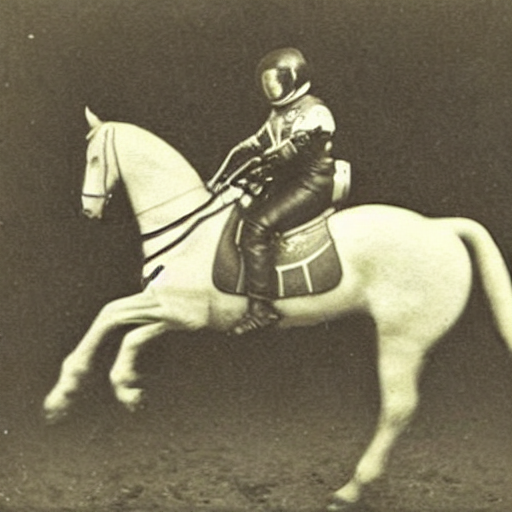

In [25]:
prompt = ["a photograph of an astronaut riding a horse"]
text_embeddings = prompt_to_emb(prompt)
latents = emb_to_latents(text_embeddings)
image = latents_to_pil(latents)
image[0]

  0%|          | 0/51 [00:00<?, ?it/s]

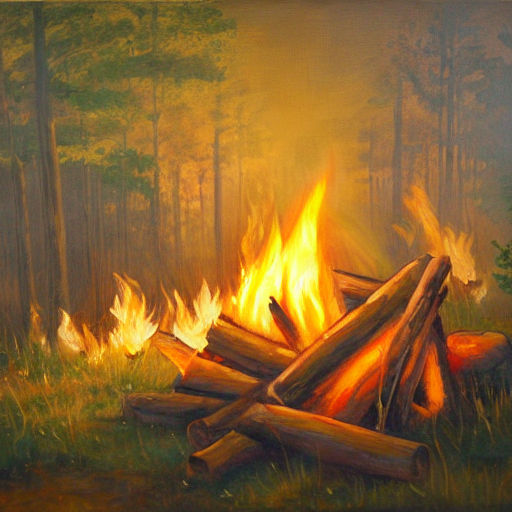

In [26]:
prompt = ["a campfire (oil on canvas)"]
text_embeddings = prompt_to_emb(prompt)
latents = emb_to_latents(text_embeddings)
image = latents_to_pil(latents)
image[0]